In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from ultralytics import YOLO

IMAGE_SIZE = (512, 512)
IMAGE_DIR = Path("/home/anawat/JJ/Chula/Chess2PGN/data")

# Chess board part configs
BILATERAL_FILTER_DIAMETER = 3
BILATERAL_FILTER_SIGMA_COLOR = 75
BILATERAL_FILTER_SIGMA_SPACE = 75

model = YOLO("/home/anawat/JJ/Chula/Chess2PGN/weights/chess-piece/best.pt")  # load a piece detection model

def detect_board_roi(frame):
    """
    Automatically detect chess board region in frame
    
    Returns:
        (x, y, w, h) bounding box of board, or None if not found
    """
    # Convert to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    
    # Apply threshold to find board (green/white squares are brighter than black bars)
    _, thresh = cv2.threshold(gray, 30, 255, cv2.THRESH_BINARY)
    
    # Find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if not contours:
        return None
    
    # Find largest contour (should be the board)
    largest_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest_contour)
    
    return (x, y, w, h)

def get_roi_from_first_frame(video_path):
    """
    Detect ROI from the first frame only
    
    Returns:
        (x, y, w, h) tuple or None
    """
    cap = cv2.VideoCapture(str(video_path))
    
    if not cap.isOpened():
        raise ValueError(f"Cannot open video: {video_path}")
    
    # Read first frame
    ret, frame = cap.read()
    cap.release()
    
    if not ret:
        raise ValueError("Cannot read first frame")
    
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    print("Detecting board region from first frame...")
    roi = detect_board_roi(frame_rgb)
    
    if roi:
        x, y, w, h = roi
        print(f"✓ Board detected at: x={x}, y={y}, w={w}, h={h}")
        print(f"  Size: {w}x{h}, Aspect ratio: {w/h:.2f}")
    else:
        print("✗ Warning: Could not detect board")
    
    return roi, frame_rgb

In [2]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import itertools

def cannyPF(img, sigma=0.25):
  med = np.median(img)
  lower = int(max(0, (1.0 - sigma) * med))
  upper = int(min(255, (1.0 + sigma) * med))
  return cv2.Canny(img, lower, upper)

def group_lines(unique_lines):
  group1, group2 = [], []
  temp_group = []
  group1_mean, group2_mean = None, None

  for i, (rho, theta) in enumerate(unique_lines):
    if group1_mean is None:
      if theta >=np.pi/3 and theta <= 2*np.pi/3:
        group1.append(i)
        group1_mean = theta
      else:
        temp_group.append(i)
    else:
      diff = abs(theta - group1_mean) 
      if diff <= np.pi/3:
        group1.append(i)
        group1_mean = np.mean([unique_lines[j][1] for j in group1])
      else:
        temp_group.append(i)

  for i in temp_group:
    rho, theta = unique_lines[i]
    diff = abs(theta - group1_mean)
    if diff > np.pi/3:
      group2.append(i)
      if group2_mean is None:
        group2_mean = theta
      else:
        group2_mean = np.mean([unique_lines[j][1] for j in group2])
    else:
      group1.append(i)
      group1_mean = np.mean([unique_lines[j][1] for j in group1])
  return group1, group2

def select_best_9_lines(group_indices, unique_lines):
  """Select 9 lines with most uniform spacing"""
  
  # Extract lines and sort by rho (handle negative rho)
  lines_with_idx = [(i, unique_lines[i][0], unique_lines[i][1]) for i in group_indices]
  
  # Normalize: if rho < 0, flip to positive and adjust theta
  normalized = []
  for idx, rho, theta in lines_with_idx:
      if rho < 0:
          rho = -rho
          theta = theta + np.pi if theta < np.pi else theta - np.pi
      normalized.append((idx, rho, theta))
  
  # Sort by rho
  normalized.sort(key=lambda x: x[1])
  sorted_indices = [x[0] for x in normalized]
  sorted_rhos = [x[1] for x in normalized]
  
  if len(sorted_indices) <= 9:
      return sorted_indices
  
  # Try all combinations
  best_indices = None
  best_score = float('inf')
  
  for combo in itertools.combinations(range(len(sorted_indices)), 9):
      combo_rhos = [sorted_rhos[i] for i in combo]
      
      # Linear fit
      x = np.arange(9)
      poly_coeffs = np.polyfit(x, combo_rhos, deg=2)
      predicted = np.polyval(poly_coeffs, x)
      mse = np.mean((combo_rhos - predicted) ** 2)
      
      if mse < best_score:
          best_score = mse
          best_indices = [sorted_indices[i] for i in combo]
  
  return best_indices

def get_line_intersections(lines_group1, lines_group2, unique_lines, img_shape):
    """Calculate intersection points between two groups of lines"""
    intersections = []
    
    for i in lines_group1:
        rho1, theta1 = unique_lines[i]
        for j in lines_group2:
            rho2, theta2 = unique_lines[j]
            
            cos1, sin1 = np.cos(theta1), np.sin(theta1)
            cos2, sin2 = np.cos(theta2), np.sin(theta2)
            
            det = cos1 * sin2 - sin1 * cos2
            
            if abs(det) > 1e-6:  # Lines not parallel
                x = (rho1 * sin2 - rho2 * sin1) / det
                y = (rho2 * cos1 - rho1 * cos2) / det
                
                # Check if intersection is within image bounds
                if 0 <= x < img_shape[1] and 0 <= y < img_shape[0]:
                    intersections.append((x, y))
    
    return intersections

def create_chess_grid(lines_group1, lines_group2, unique_lines, img_shape):
    """Create 8x8 chess grid from 9x9 line intersections"""
    
    # Sort lines by rho to get consistent ordering
    def get_sorted_lines(group_indices):
        lines_data = []
        for i in group_indices:
            rho, theta = unique_lines[i]
            if rho < 0:
                rho = -rho
                theta = theta + np.pi if theta < np.pi else theta - np.pi
            lines_data.append((i, rho, theta))
        lines_data.sort(key=lambda x: x[1])
        return [x[0] for x in lines_data]
    
    sorted_group1 = get_sorted_lines(lines_group1)
    sorted_group2 = get_sorted_lines(lines_group2)
    
    # Calculate all intersection points in order
    grid_points = np.zeros((9, 9, 2))
    
    for i, idx1 in enumerate(sorted_group1):
        for j, idx2 in enumerate(sorted_group2):
            rho1, theta1 = unique_lines[idx1]
            rho2, theta2 = unique_lines[idx2]
            
            cos1, sin1 = np.cos(theta1), np.sin(theta1)
            cos2, sin2 = np.cos(theta2), np.sin(theta2)
            
            det = cos1 * sin2 - sin1 * cos2
            
            if abs(det) > 1e-6:
                x = (rho1 * sin2 - rho2 * sin1) / det
                y = (rho2 * cos1 - rho1 * cos2) / det
                grid_points[i, j] = [x, y]
    
    return grid_points, sorted_group1, sorted_group2

def get_cell_centers(grid_points):
    """Calculate center points of 64 chess squares"""
    cell_centers = {}
    files = 'hgfedcba'
    ranks = '12345678'  # Top to bottom in image
    
    for row in range(8):
        for col in range(8):
            # Get 4 corners of the cell
            tl = grid_points[row, col]
            tr = grid_points[row, col + 1]
            bl = grid_points[row + 1, col]
            br = grid_points[row + 1, col + 1]
            
            # Calculate center
            center_x = (tl[0] + tr[0] + bl[0] + br[0]) / 4
            center_y = (tl[1] + tr[1] + bl[1] + br[1]) / 4
            
            # Map to chess notation
            square = files[col] + ranks[row]
            cell_centers[square] = {
                'center': (center_x, center_y),
                'corners': [tl, tr, br, bl]  # clockwise from top-left
            }
    
    return cell_centers

def point_in_cell(point, cell_data):
    """Check if a point is inside a cell using its corners"""
    px, py = point
    corners = cell_data['corners']
    
    # Use simple bounding box check (can be improved with polygon test)
    xs = [c[0] for c in corners]
    ys = [c[1] for c in corners]
    
    return min(xs) <= px <= max(xs) and min(ys) <= py <= max(ys)

def find_representative_lines(img):
  # Detect lines and find representative lines
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  bilateral = cv2.bilateralFilter(gray, d=(BILATERAL_FILTER_DIAMETER), sigmaColor=75, sigmaSpace=75)
  canny = cannyPF(bilateral, sigma=0.33)
  lines = cv2.HoughLines(canny, 1, np.pi/720.0, 50, np.array([]), 0, 0)
  lines_best = np.squeeze(lines)[:100]

  scaler = StandardScaler()
  lines_normalized = scaler.fit_transform(lines_best)
  clustering = DBSCAN(eps=0.05, min_samples=2).fit(lines_normalized)
  labels = clustering.labels_

  unique_lines = []
  for label in set(labels):
    if label != -1:  # Not noise
      cluster_lines = lines_best[labels == label]
      avg_rho = np.mean(cluster_lines[:, 0])
      avg_theta = np.mean(cluster_lines[:, 1])
      unique_lines.append([avg_rho, avg_theta])

  group1, group2 = group_lines(unique_lines)

  best_group1 = select_best_9_lines(group1, unique_lines)
  best_group2 = select_best_9_lines(group2, unique_lines)

  return best_group1, best_group2, unique_lines

def get_chess_grid(img, visualize=False):
  best_group1, best_group2, unique_lines = find_representative_lines(img)
  grid_points, sorted_g1, sorted_g2 = create_chess_grid(
      best_group1, best_group2, unique_lines, img.shape
  )
  cell_centers = get_cell_centers(grid_points)

  if visualize:
    # Visualize grid
    canvas = img.copy()

    # Draw grid lines
    for i in sorted_g1:
        rho, theta = unique_lines[i]
        a, b = np.cos(theta), np.sin(theta)
        x0, y0 = a * rho, b * rho
        x1, y1 = int(x0 + 1000 * (-b)), int(y0 + 1000 * a)
        x2, y2 = int(x0 - 1000 * (-b)), int(y0 - 1000 * a)
        cv2.line(canvas, (x1, y1), (x2, y2), (0, 255, 0), 1)

    for i in sorted_g2:
        rho, theta = unique_lines[i]
        a, b = np.cos(theta), np.sin(theta)
        x0, y0 = a * rho, b * rho
        x1, y1 = int(x0 + 1000 * (-b)), int(y0 + 1000 * a)
        x2, y2 = int(x0 - 1000 * (-b)), int(y0 - 1000 * a)
        cv2.line(canvas, (x1, y1), (x2, y2), (0, 0, 255), 1)

    # Draw cell centers and labels
    for square, cell_data in cell_centers.items():
        cx, cy = cell_data['center']
        cv2.circle(canvas, (int(cx), int(cy)), 3, (255, 0, 255), -1)
        cv2.putText(canvas, square, (int(cx)-10, int(cy)+5), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 1)

    plt.figure(figsize=(5, 5))
    plt.imshow(canvas)
    plt.title('Chess Grid with Square Labels')
    plt.show()

    print(f"\nGrid created with {len(cell_centers)} squares")
    print("\nSample cell centers:")
    for square in ['a8', 'a1', 'h8', 'h1']:
        center = cell_centers[square]['center']
        print(f"  {square}: ({center[0]:.1f}, {center[1]:.1f})")

  return cell_centers, unique_lines

In [3]:
def map_pieces_to_grid(yolo_results, cell_centers, weight_bottom=0.7):
    """
    Map detected pieces to chess squares using weighted average of bbox center and bottom-center
    
    Args:
        yolo_results: YOLO detection results
        cell_centers: Dictionary of chess square centers
        weight_bottom: Weight for bottom-center (default 0.7), remaining weight goes to bbox center
    """
    board = {square: None for square in cell_centers.keys()}
    
    for box in yolo_results[0].boxes:
        # Get bounding box info
        x_center = float(box.xywh[0][0])
        y_center = float(box.xywh[0][1])
        width = float(box.xywh[0][2])
        height = float(box.xywh[0][3])
        
        # Calculate BOTTOM CENTER of bounding box (where piece actually sits)
        x_bottom_center = x_center
        y_bottom_center = y_center + (height / 2)
        
        # Calculate WEIGHTED AVERAGE of center and bottom-center
        weight_center = 1.0 - weight_bottom
        x_weighted = weight_bottom * x_bottom_center + weight_center * x_center
        y_weighted = weight_bottom * y_bottom_center + weight_center * y_center
        
        class_id = int(box.cls[0])
        class_name = yolo_results[0].names[class_id]
        confidence = float(box.conf[0])
        
        # Find which square contains this piece using weighted position
        for square, cell_data in cell_centers.items():
            if point_in_cell((x_weighted, y_weighted), cell_data):
                # Handle multiple detections: keep highest confidence
                # if board[square] is not None:
                #     print(f"Square {square} already has {board[square]['piece']} with confidence {board[square]['confidence']:.2f}. New piece: {class_name} with confidence {confidence:.2f}")
                if board[square] is None or confidence > board[square]['confidence']:
                    board[square] = {
                        'piece': class_name,
                        'confidence': confidence,
                        'position': (x_weighted, y_weighted),  # Store weighted position
                        'bbox_center': (x_center, y_center),  # Keep for visualization
                        'bottom_center': (x_bottom_center, y_bottom_center)  # Keep for debugging
                    }
                break
    
    return board

In [4]:
def detect_orientation_by_piece_clustering(board_state, img_shape, verbose=False):
    """
    Detect board orientation by analyzing where white pieces cluster
    White pieces should be at the TOP in standard orientation
    Returns: rotation angle in degrees (0, 90, 180, 270)
    """
    white_pieces = []
    black_pieces = []
    
    # Collect piece positions
    for square, piece_data in board_state.items():
        if piece_data is not None:
            piece_name = piece_data['piece']
            x, y = piece_data['position']
            
            if piece_name[0].lower() == 'w':
                white_pieces.append({'square': square, 'x': x, 'y': y})
            else:
                black_pieces.append({'square': square, 'x': x, 'y': y})
    
    if len(white_pieces) < 2 or len(black_pieces) < 2:
        print("Not enough pieces detected for orientation")
        return 0
    
    # Calculate center of mass for each color
    white_center_y = np.mean([p['y'] for p in white_pieces])
    black_center_y = np.mean([p['y'] for p in black_pieces])
    white_center_x = np.mean([p['x'] for p in white_pieces])
    black_center_x = np.mean([p['x'] for p in black_pieces])
    
    img_height, img_width = img_shape[:2]
    
    # Determine orientation based on piece clustering
    # Calculate which edge white pieces are closest to
    dist_to_top = white_center_y
    dist_to_bottom = img_height - white_center_y
    dist_to_left = white_center_x
    dist_to_right = img_width - white_center_x
    
    edges = {
        'top': dist_to_top,
        'bottom': dist_to_bottom,
        'left': dist_to_left,
        'right': dist_to_right
    }
    
    closest_edge = min(edges, key=edges.get)
    
    # Map edge to rotation (white should be at TOP)
    rotation_map = {
        'top': 0,       # Standard: white at top
        'bottom': 180,  # Inverted: white at bottom
        'right': 90,    # Rotated: white on right
        'left': 270     # Rotated: white on left
    }
    
    rotation = rotation_map[closest_edge]
    
    if verbose:
      print(f"White pieces center: ({white_center_x:.1f}, {white_center_y:.1f})")
      print(f"Black pieces center: ({black_center_x:.1f}, {black_center_y:.1f})")
      print(f"Closest edge for white: {closest_edge}")
    print(f"Detected rotation: {rotation}°")
    
    return rotation

In [5]:
def stream_extract_and_group_frames(video_path, roi, cell_centers, yolo_model,
                                    change_threshold=0.05,
                                    interval_seconds=1, rotation_angle=0, confidence_threshold=0.2, verbose=False):
    """
    Stream video, filter stable frames using progressive baseline, group consecutive frames,
    and compute consensus for each state WITH DUPLICATE DETECTION.
    
    IMPROVEMENTS:
    - Hard threshold reset (prevents cascade failures)
    - Baseline age limit (prevents long-term drift)
    
    Args:
        video_path: Path to video file
        roi: (x, y, w, h) tuple for cropping
        cell_centers: Chess grid cell centers
        yolo_model: YOLO model for piece detection
        change_threshold: Maximum allowed change percentage (0.05 = 5% SOFT threshold)
        interval_seconds: Time interval between frame checks
        rotation_angle: Rotation angle to apply (0, 90, 180, 270)
        confidence_threshold: Minimum YOLO confidence for piece detection
        
    Returns:
        List of board states with consensus boards (minimal memory)
    """
    cap = cv2.VideoCapture(str(video_path))
    
    if not cap.isOpened():
        raise ValueError(f"Cannot open video: {video_path}")
    
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    duration = total_frames / fps
    
    # NEW: Define dual thresholds
    SOFT_THRESHOLD = change_threshold          # 5% (normal validation)
    HARD_THRESHOLD = change_threshold * 2.0    # 10% (force baseline reset)
    BASELINE_MAX_AGE = 50                      # Maximum frames before forced sanity check
    
    if verbose:
      print(f"\nVideo Processing:")
      print(f"  FPS: {fps:.2f}")
      print(f"  Total frames: {total_frames}")
      print(f"  Duration: {duration:.2f} seconds")
      print(f"  Rotation: {rotation_angle}°")
      print(f"  Soft threshold: {SOFT_THRESHOLD*100:.1f}%")
      print(f"  Hard threshold: {HARD_THRESHOLD*100:.1f}%")
      print(f"  Baseline max age: {BASELINE_MAX_AGE} frames")
      print(f"  Confidence threshold: {confidence_threshold}")
      print("="*70)
    
    def calculate_difference(frame1, frame2):
        """Calculate frame difference percentage"""
        gray1 = cv2.cvtColor(frame1, cv2.COLOR_RGB2GRAY)
        gray2 = cv2.cvtColor(frame2, cv2.COLOR_RGB2GRAY)
        diff = cv2.absdiff(gray1, gray2)
        _, thresh = cv2.threshold(diff, 25, 255, cv2.THRESH_BINARY)
        changed_pixels = np.count_nonzero(thresh)
        return changed_pixels / thresh.size
    
    def process_and_rotate_frame(frame_bgr, roi, rotation_angle):
        """Process frame: convert, crop, resize, rotate"""
        frame_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
        
        if roi:
            x, y, w, h = roi
            frame_cropped = frame_rgb[y:y+h, x:x+w]
        else:
            frame_cropped = frame_rgb
        
        frame_resized = cv2.resize(frame_cropped, IMAGE_SIZE, 
                                   interpolation=cv2.INTER_LINEAR)
        
        if rotation_angle == 90:
            frame_rotated = cv2.rotate(frame_resized, cv2.ROTATE_90_COUNTERCLOCKWISE)
        elif rotation_angle == 180:
            frame_rotated = cv2.rotate(frame_resized, cv2.ROTATE_180)
        elif rotation_angle == 270:
            frame_rotated = cv2.rotate(frame_resized, cv2.ROTATE_90_CLOCKWISE)
        else:
            frame_rotated = frame_resized
        
        return frame_rotated
    
    def get_consensus_from_frames(frames_list, yolo_model, cell_centers, confidence_threshold, maximum_frames=10):
        """Get consensus board from frame list using voting"""

        if len(frames_list) > maximum_frames:
            step = len(frames_list) / maximum_frames
            frames_list = [frames_list[int(i * step)] for i in range(maximum_frames)]

        square_votes = {square: {} for square in cell_centers.keys()}
        
        for frame_data in frames_list:
            frame = frame_data['frame']
            results = yolo_model(frame, verbose=False)
            board = map_pieces_to_grid(results, cell_centers)
            
            for square, piece_data in board.items():
                if piece_data is not None and piece_data['confidence'] >= confidence_threshold:
                    piece_name = piece_data['piece']
                    
                    if piece_name not in square_votes[square]:
                        square_votes[square][piece_name] = {
                            'count': 0,
                            'confidences': []
                        }
                    
                    square_votes[square][piece_name]['count'] += 1
                    square_votes[square][piece_name]['confidences'].append(piece_data['confidence'])
        
        consensus_board = {}
        total_frames = len(frames_list)
        
        for square, votes in square_votes.items():
            if len(votes) == 0:
                consensus_board[square] = None
            else:
                best_piece = max(votes.items(), key=lambda x: x[1]['count'])
                piece_name = best_piece[0]
                vote_count = best_piece[1]['count']
                confidences = best_piece[1]['confidences']
                
                vote_percentage = vote_count / total_frames
                avg_confidence = np.mean(confidences)
                
                if vote_percentage > 0.5 or avg_confidence > 0.85:
                    consensus_board[square] = {
                        'piece': piece_name,
                        'confidence': avg_confidence,
                        'votes': f"{vote_count}/{total_frames}",
                        'vote_percentage': vote_percentage
                    }
                else:
                    consensus_board[square] = None
        
        return consensus_board
    
    def boards_are_identical(board1, board2, tolerance=1, verbose=False):
        """
        Compare two consensus boards for similarity.
        
        Args:
            board1, board2: Consensus board dictionaries
            tolerance: Number of allowed mismatches (default 1)
            
        Returns:
            True if boards are identical (within tolerance)
        """
        mismatches = 0
        
        for square in board1.keys():
            piece1 = board1[square]
            piece2 = board2[square]
            
            # Both empty
            if piece1 is None and piece2 is None:
                continue
            
            # One empty, one occupied
            if (piece1 is None) != (piece2 is None):
                mismatches += 1
                continue
            
            # Both occupied - compare piece types (ignore color for robustness)
            type1 = piece1['piece'].split('-')[-1]
            type2 = piece2['piece'].split('-')[-1]
            
            if type1 != type2:
                mismatches += 1
        
        return mismatches <= tolerance
    
    # Initialize
    baseline_frame = None
    baseline_frame_number = 0  # NEW: Track baseline age
    current_group_frames = []
    grouped_states = []
    frame_interval = int(fps * interval_seconds)
    frame_number = 0
    
    if verbose:
      print("\nFiltering frames (dual-threshold baseline with age tracking)...")
      print("="*70)
    
    # Step 1: Stream and filter valid frames
    while frame_number < total_frames:
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
        ret, frame_bgr = cap.read()
        
        if not ret:
            break
        
        timestamp = frame_number / fps
        frame_processed = process_and_rotate_frame(frame_bgr, roi, rotation_angle)
        
        # First frame - initialize baseline
        if baseline_frame is None:
            baseline_frame = frame_processed
            baseline_frame_number = frame_number
            current_group_frames.append({
                'frame': frame_processed,
                'timestamp': timestamp,
                'frame_number': frame_number,
                'diff_from_baseline': 0.0
            })
            if verbose:
                print(f"Frame {frame_number:4d} | t={timestamp:6.1f}s | "
                      f"Change: 0.00% | ✓ VALID (initial baseline)")
            frame_number += frame_interval
            continue
        
        # NEW: Check baseline age
        baseline_age = (frame_number - baseline_frame_number) // frame_interval
        
        # Calculate difference from baseline
        diff_percentage = calculate_difference(baseline_frame, frame_processed)
        
        # NEW: Dual-threshold decision tree
        if diff_percentage <= SOFT_THRESHOLD:
            # ===== VALID FRAME (below soft threshold) =====
            status = "✓ VALID"
            baseline_info = ""
            
            current_group_frames.append({
                'frame': frame_processed,
                'timestamp': timestamp,
                'frame_number': frame_number,
                'diff_from_baseline': diff_percentage
            })
            
            # Update baseline if frame is drifting
            if diff_percentage <= (SOFT_THRESHOLD / 3):
                baseline_frame = frame_processed
                baseline_frame_number = frame_number
                baseline_info = "(baseline updated)"
            
            # NEW: Check if baseline is too old
            if baseline_age >= BASELINE_MAX_AGE:
                baseline_frame = frame_processed
                baseline_frame_number = frame_number
                baseline_info = "(baseline aged out - reset)"
                if verbose:
                    print(f"  ⚠ Baseline aged {baseline_age} frames, forcing reset")
            
            if verbose:
              print(f"Frame {frame_number:4d} | t={timestamp:6.1f}s | "
                    f"Change: {diff_percentage*100:5.2f}% | {status} {baseline_info}")
            
        elif SOFT_THRESHOLD < diff_percentage <= HARD_THRESHOLD:
            # ===== REJECTED - Medium change (force baseline reset) =====
            status = "✗ REJECTED"
            
            if verbose:
              print(f"Frame {frame_number:4d} | t={timestamp:6.1f}s | "
                    f"Change: {diff_percentage*100:5.2f}% | {status} (medium change)")
            
            # Save current group as a state
            if len(current_group_frames) > 0:
                state_id = len(grouped_states)
                if verbose:
                    print(f"  → Processing State {state_id} ({len(current_group_frames)} frames)...")
                
                # Compute consensus
                consensus_board = get_consensus_from_frames(
                    current_group_frames, yolo_model, cell_centers, confidence_threshold
                )
                
                piece_count = sum(1 for v in consensus_board.values() if v is not None)
                vote_percentages = [v['vote_percentage'] for v in consensus_board.values() 
                                   if v is not None]
                avg_vote_pct = np.mean(vote_percentages) if vote_percentages else 0
                
                # **LOOKAHEAD MERGE**: Check if identical to previous state
                if len(grouped_states) > 0:
                    prev_state = grouped_states[-1]
                    if boards_are_identical(prev_state['consensus_board'], consensus_board, tolerance=1):
                        if verbose:
                          print(f"  ⚙ MERGE: State {state_id} identical to State {prev_state['state_id']}, extending previous state")
                        
                        # Extend previous state instead of creating new one
                        grouped_states[-1]['time_end'] = current_group_frames[-1]['timestamp']
                        grouped_states[-1]['duration'] = grouped_states[-1]['time_end'] - grouped_states[-1]['time_start']
                        grouped_states[-1]['frame_count'] += len(current_group_frames)
                        
                        if verbose:
                          print(f"  ✓ Extended State {prev_state['state_id']}: now {grouped_states[-1]['frame_count']} frames "
                                f"({grouped_states[-1]['time_start']:.1f}s - {grouped_states[-1]['time_end']:.1f}s)")
                        
                        # Clear group
                        current_group_frames = []
                        
                        # NEW: Force baseline reset
                        baseline_frame = frame_processed
                        baseline_frame_number = frame_number
                        if verbose:
                            print(f"  🔄 Baseline reset to frame {frame_number} (preventing cascade)")
                        
                        frame_number += frame_interval
                        continue
                
                # Not identical - create new state
                grouped_states.append({
                    'state_id': state_id,
                    'consensus_board': consensus_board,
                    'piece_count': piece_count,
                    'avg_consensus': avg_vote_pct,
                    'frame_count': len(current_group_frames),
                    'time_start': current_group_frames[0]['timestamp'],
                    'time_end': current_group_frames[-1]['timestamp'],
                    'duration': current_group_frames[-1]['timestamp'] - current_group_frames[0]['timestamp'],
                    'representative_frame': current_group_frames[0]['frame']
                })
                
                if verbose:
                  print(f"  ✓ State {state_id}: {len(current_group_frames)} frames "
                        f"({current_group_frames[0]['timestamp']:.1f}s - {current_group_frames[-1]['timestamp']:.1f}s) | "
                        f"{piece_count} pieces, consensus: {avg_vote_pct*100:.1f}%")
                
                # Clear group
                current_group_frames = []
            
            # NEW: Force baseline reset
            baseline_frame = frame_processed
            baseline_frame_number = frame_number
            if verbose:
                print(f"  🔄 Baseline reset to frame {frame_number} (medium change detected)")
            
        else:  # diff_percentage > HARD_THRESHOLD
            # ===== REJECTED - Extreme change (hand/arm, force baseline reset) =====
            status = "✗ REJECTED"
            
            if verbose:
              print(f"Frame {frame_number:4d} | t={timestamp:6.1f}s | "
                    f"Change: {diff_percentage*100:5.2f}% | {status} (extreme change)")
            
            # Save current group as a state
            if len(current_group_frames) > 0:
                state_id = len(grouped_states)
                if verbose:
                    print(f"  → Processing State {state_id} ({len(current_group_frames)} frames)...")
                
                # Compute consensus
                consensus_board = get_consensus_from_frames(
                    current_group_frames, yolo_model, cell_centers, confidence_threshold
                )
                
                piece_count = sum(1 for v in consensus_board.values() if v is not None)
                vote_percentages = [v['vote_percentage'] for v in consensus_board.values() 
                                   if v is not None]
                avg_vote_pct = np.mean(vote_percentages) if vote_percentages else 0
                
                # **LOOKAHEAD MERGE**: Check if identical to previous state
                if len(grouped_states) > 0:
                    prev_state = grouped_states[-1]
                    if boards_are_identical(prev_state['consensus_board'], consensus_board, tolerance=1):
                        if verbose:
                          print(f"  ⚙ MERGE: State {state_id} identical to State {prev_state['state_id']}, extending previous state")
                        
                        # Extend previous state instead of creating new one
                        grouped_states[-1]['time_end'] = current_group_frames[-1]['timestamp']
                        grouped_states[-1]['duration'] = grouped_states[-1]['time_end'] - grouped_states[-1]['time_start']
                        grouped_states[-1]['frame_count'] += len(current_group_frames)
                        
                        if verbose:
                          print(f"  ✓ Extended State {prev_state['state_id']}: now {grouped_states[-1]['frame_count']} frames "
                                f"({grouped_states[-1]['time_start']:.1f}s - {grouped_states[-1]['time_end']:.1f}s)")
                        
                        # Clear group
                        current_group_frames = []
                        
                        # NEW: Force baseline reset
                        baseline_frame = frame_processed
                        baseline_frame_number = frame_number
                        if verbose:
                            print(f"  🔄 Baseline reset to frame {frame_number} (preventing cascade)")
                        
                        frame_number += frame_interval
                        continue
                
                # Not identical - create new state
                grouped_states.append({
                    'state_id': state_id,
                    'consensus_board': consensus_board,
                    'piece_count': piece_count,
                    'avg_consensus': avg_vote_pct,
                    'frame_count': len(current_group_frames),
                    'time_start': current_group_frames[0]['timestamp'],
                    'time_end': current_group_frames[-1]['timestamp'],
                    'duration': current_group_frames[-1]['timestamp'] - current_group_frames[0]['timestamp'],
                    'representative_frame': current_group_frames[0]['frame']
                })
                
                if verbose:
                  print(f"  ✓ State {state_id}: {len(current_group_frames)} frames "
                        f"({current_group_frames[0]['timestamp']:.1f}s - {current_group_frames[-1]['timestamp']:.1f}s) | "
                        f"{piece_count} pieces, consensus: {avg_vote_pct*100:.1f}%")
                
                # Clear group
                current_group_frames = []
            
            # NEW: Force baseline reset
            baseline_frame = frame_processed
            baseline_frame_number = frame_number
            if verbose:
                print(f"  🔄 Baseline reset to frame {frame_number} (extreme change detected)")
        
        frame_number += frame_interval
    
    # Save final group (same as before)
    if len(current_group_frames) > 0:
        state_id = len(grouped_states)
        print(f"\n  → Processing final State {state_id} ({len(current_group_frames)} frames)...")
        
        consensus_board = get_consensus_from_frames(
            current_group_frames, yolo_model, cell_centers, confidence_threshold
        )
        
        piece_count = sum(1 for v in consensus_board.values() if v is not None)
        vote_percentages = [v['vote_percentage'] for v in consensus_board.values() 
                           if v is not None]
        avg_vote_pct = np.mean(vote_percentages) if vote_percentages else 0
        
        # **LOOKAHEAD MERGE**: Check final state too
        if len(grouped_states) > 0:
            prev_state = grouped_states[-1]
            if boards_are_identical(prev_state['consensus_board'], consensus_board, tolerance=1):
                print(f"  ⚙ MERGE: Final state identical to State {prev_state['state_id']}, extending")
                
                grouped_states[-1]['time_end'] = current_group_frames[-1]['timestamp']
                grouped_states[-1]['duration'] = grouped_states[-1]['time_end'] - grouped_states[-1]['time_start']
                grouped_states[-1]['frame_count'] += len(current_group_frames)
                
                print(f"  ✓ Extended State {prev_state['state_id']}: now {grouped_states[-1]['frame_count']} frames")
            else:
                # Create final state
                grouped_states.append({
                    'state_id': state_id,
                    'consensus_board': consensus_board,
                    'piece_count': piece_count,
                    'avg_consensus': avg_vote_pct,
                    'frame_count': len(current_group_frames),
                    'time_start': current_group_frames[0]['timestamp'],
                    'time_end': current_group_frames[-1]['timestamp'],
                    'duration': current_group_frames[-1]['timestamp'] - current_group_frames[0]['timestamp'],
                    'representative_frame': current_group_frames[0]['frame']
                })
                
                if verbose:
                  print(f"  ✓ State {state_id}: {len(current_group_frames)} frames "
                        f"({current_group_frames[0]['timestamp']:.1f}s - {current_group_frames[-1]['timestamp']:.1f}s) | "
                        f"{piece_count} pieces, consensus: {avg_vote_pct*100:.1f}%")
        else:
            # First state is also final state
            grouped_states.append({
                'state_id': state_id,
                'consensus_board': consensus_board,
                'piece_count': piece_count,
                'avg_consensus': avg_vote_pct,
                'frame_count': len(current_group_frames),
                'time_start': current_group_frames[0]['timestamp'],
                'time_end': current_group_frames[-1]['timestamp'],
                'duration': current_group_frames[-1]['timestamp'] - current_group_frames[0]['timestamp'],
                'representative_frame': current_group_frames[0]['frame']
            })
            
            if verbose:
              print(f"  ✓ State {state_id}: {len(current_group_frames)} frames")
    
    cap.release()
    
    # Post-processing (same as before)
    if verbose:
      print("\n" + "="*70)
      print("POST-PROCESSING: Scanning for consecutive duplicates...")
      print("="*70)
    
    merged_states = []
    i = 0
    
    while i < len(grouped_states):
        current_state = grouped_states[i]
        
        # Look ahead for duplicates
        j = i + 1
        while j < len(grouped_states):
            next_state = grouped_states[j]
            
            if boards_are_identical(current_state['consensus_board'], 
                                   next_state['consensus_board'], 
                                   tolerance=1):
                if verbose:
                  print(f"  ⚙ MERGE: State {next_state['state_id']} identical to State {current_state['state_id']}")
                
                # Merge into current
                current_state['time_end'] = next_state['time_end']
                current_state['duration'] = current_state['time_end'] - current_state['time_start']
                current_state['frame_count'] += next_state['frame_count']
                
                j += 1
            else:
                break
        
        merged_states.append(current_state)
        i = j
    
    # Renumber states
    for idx, state in enumerate(merged_states):
        state['state_id'] = idx
    
    if verbose:
      print(f"✓ Merged {len(grouped_states)} states → {len(merged_states)} unique states")
      print("="*70)
      print(f"Valid frames: {sum(s['frame_count'] for s in merged_states)}")
      print(f"Rejected frames: {(frame_number // frame_interval) - sum(s['frame_count'] for s in merged_states)}")
      print(f"Result: {len(merged_states)} distinct board states")
      print("="*70)
    
    return merged_states

# ...existing code...

In [6]:
import chess
from itertools import combinations, permutations

# ============================================================================
# HELPER FUNCTIONS
# ============================================================================

def get_piece_type(piece_name):
    """Extract piece type without color: 'white-pawn' -> 'pawn'"""
    if piece_name is None:
        return None
    return piece_name.split('-')[-1].lower()

def get_piece_color(piece_name):
    """Extract color: 'white-pawn' -> 'white'"""
    if piece_name is None:
        return None
    return piece_name.split('-')[0].lower()


# ============================================================================
# BOARD STATE TO FEN CONVERSION
# ============================================================================

def consensus_board_to_fen(consensus_board, turn='w'):
    """
    Convert consensus board to FEN notation.
    
    Args:
        consensus_board: Your board state dictionary
        turn: 'w' or 'b' for whose turn it is
        
    Returns:
        FEN string
    """
    # Initialize 8x8 board
    board_array = [[None]*8 for _ in range(8)]
    
    # Map pieces to board array
    for square, piece_data in consensus_board.items():
        if piece_data is not None:
            file_idx = ord(square[0]) - ord('a')  # a-h → 0-7
            rank_idx = int(square[1]) - 1          # 1-8 → 0-7
            
            piece_type = get_piece_type(piece_data['piece'])
            piece_color = get_piece_color(piece_data['piece'])
            
            # Map to FEN characters
            piece_map = {
                'pawn': 'P', 'knight': 'N', 'bishop': 'B',
                'rook': 'R', 'queen': 'Q', 'king': 'K'
            }
            
            fen_char = piece_map.get(piece_type, 'P')
            if piece_color == 'black':
                fen_char = fen_char.lower()
            
            # FEN ranks are from 8 to 1 (top to bottom)
            board_array[7 - rank_idx][file_idx] = fen_char
    
    # Convert to FEN string
    fen_rows = []
    for row in board_array:
        empty_count = 0
        row_str = ""
        for square in row:
            if square is None:
                empty_count += 1
            else:
                if empty_count > 0:
                    row_str += str(empty_count)
                    empty_count = 0
                row_str += square
        if empty_count > 0:
            row_str += str(empty_count)
        fen_rows.append(row_str)
    
    fen_board = "/".join(fen_rows)
    
    # Default: assume castling available, no en passant
    return f"{fen_board} {turn} KQkq - 0 1"


# ============================================================================
# COLOR PATTERN DETECTION
# ============================================================================

def extract_move_colors(board_states):
    """Extract color sequence from board state transitions."""
    color_sequence = []
    
    for i in range(len(board_states) - 1):
        board_before = board_states[i]['consensus_board']
        board_after = board_states[i + 1]['consensus_board']
        
        moved_colors = []
        
        for square in board_before.keys():
            piece_before = board_before.get(square)
            piece_after = board_after.get(square)
            
            if piece_before and not piece_after:
                color = get_piece_color(piece_before['piece'])
                if color:
                    moved_colors.append(color)
        
        if moved_colors:
            from collections import Counter
            most_common_color = Counter(moved_colors).most_common(1)[0][0]
            color_sequence.append(most_common_color)
        else:
            color_sequence.append(None)
    
    return color_sequence


def detect_starting_color(color_sequence, threshold=0.75):
    """Detect which color starts first using pattern voting."""
    if len(color_sequence) < 2:
        return 'white'
    
    valid_colors = [c for c in color_sequence if c is not None]
    
    if len(valid_colors) < 2:
        return 'white'
    
    white_first_pattern = ['white', 'black'] * (len(valid_colors) // 2 + 1)
    white_matches = sum(1 for i, c in enumerate(valid_colors) 
                       if i < len(white_first_pattern) and c == white_first_pattern[i])
    
    black_first_pattern = ['black', 'white'] * (len(valid_colors) // 2 + 1)
    black_matches = sum(1 for i, c in enumerate(valid_colors) 
                       if i < len(black_first_pattern) and c == black_first_pattern[i])
    
    white_percent = white_matches / len(valid_colors)
    black_percent = black_matches / len(valid_colors)
    
    print(f"\n=== STARTING COLOR DETECTION ===")
    print(f"Color sequence: {valid_colors[:10]}{'...' if len(valid_colors) > 10 else ''}")
    print(f"White-first match: {white_percent*100:.1f}%")
    print(f"Black-first match: {black_percent*100:.1f}%")
    
    if white_percent > threshold:
        print(f"✓ White starts first (confidence: {white_percent*100:.1f}%)")
        return 'white'
    elif black_percent > threshold:
        print(f"✓ Black starts first (confidence: {black_percent*100:.1f}%)")
        return 'black'
    else:
        fallback = valid_colors[0] if valid_colors else 'white'
        print(f"⚠ Low confidence, using first move color: {fallback}")
        return fallback


# ============================================================================
# MOVE DETECTION WITH BOARD DIFF
# ============================================================================

def detect_board_changes(board_before, board_after):
    """
    Detect all changes between two board states.
    Returns lists of disappeared, appeared pieces (not matched to patterns).
    """
    disappeared = []
    appeared = []
    
    all_squares = set(board_before.keys()) | set(board_after.keys())
    
    for square in all_squares:
        piece_before = board_before.get(square)
        piece_after = board_after.get(square)
        
        name_before = piece_before['piece'] if piece_before else None
        name_after = piece_after['piece'] if piece_after else None
        
        type_before = get_piece_type(name_before)
        type_after = get_piece_type(name_after)
        
        color_before = get_piece_color(name_before)
        color_after = get_piece_color(name_after)
        
        # Piece disappeared
        if piece_before and not piece_after:
            disappeared.append({
                'square': square,
                'type': type_before,
                'color': color_before,
                'confidence': piece_before['confidence']
            })
        # Piece appeared
        elif not piece_before and piece_after:
            appeared.append({
                'square': square,
                'type': type_after,
                'color': color_after,
                'confidence': piece_after['confidence']
            })
        # Piece changed type
        elif type_before != type_after:
            # Check if it's a true promotion (same color)
            if color_before == color_after:
                # Keep as appeared (promoted piece)
                appeared.append({
                    'square': square,
                    'type': type_after,
                    'color': color_after,
                    'confidence': piece_after['confidence'],
                    'is_promotion': True,
                    'promoted_from': type_before
                })
            else:
                # Different colors = capture, split into disappeared + appeared
                disappeared.append({
                    'square': square,
                    'type': type_before,
                    'color': color_before,
                    'confidence': piece_before['confidence']
                })
                appeared.append({
                    'square': square,
                    'type': type_after,
                    'color': color_after,
                    'confidence': piece_after['confidence']
                })
    
    return disappeared, appeared


# ============================================================================
# 1-TO-1 MAPPING WITH CHESS ENGINE VALIDATION
# ============================================================================

def generate_move_candidates(disappeared, appeared, expected_color):
    """
    Generate all possible 1-to-1 mappings between disappeared and appeared pieces.
    Filters by expected moving color.
    
    Returns: List of candidate mappings
    """
    # Filter disappeared pieces by expected color
    moving_pieces = [d for d in disappeared if d['color'] == expected_color]
    
    if not moving_pieces or not appeared:
        return []
    
    candidates = []
    
    # Try all combinations of moving pieces
    for from_piece in moving_pieces:
        for to_piece in appeared:
            # Basic validation: piece types should match (except promotions)
            if from_piece['type'] == to_piece['type']:
                # Normal move or capture
                candidates.append({
                    'from': from_piece,
                    'to': to_piece,
                    'type': 'normal' if from_piece['square'] != to_piece['square'] else 'error'
                })
            elif from_piece['type'] == 'pawn' and to_piece.get('is_promotion'):
                # Promotion
                candidates.append({
                    'from': from_piece,
                    'to': to_piece,
                    'type': 'promotion'
                })
    
    return candidates


def score_move_with_engine(candidate, board_fen):
    """
    Score a move candidate using chess engine validation.
    
    Returns: (score, legal_move_obj, check_status)
    """
    try:
        board = chess.Board(board_fen)
    except:
        # Invalid FEN
        return 0.0, None, ''
    
    from_sq = candidate['from']['square']
    to_sq = candidate['to']['square']
    
    # Convert squares to chess.Square
    try:
        from_square = chess.parse_square(from_sq)
        to_square = chess.parse_square(to_sq)
    except:
        return 0.0, None, ''
    
    # Check if move is legal
    move_uci = f"{from_sq}{to_sq}"
    
    # Handle promotions
    if candidate['type'] == 'promotion':
        promoted_to = candidate['to']['type']
        promo_map = {'queen': 'q', 'rook': 'r', 'bishop': 'b', 'knight': 'n'}
        move_uci += promo_map.get(promoted_to, 'q')
    
    try:
        move_obj = chess.Move.from_uci(move_uci)
    except:
        return 0.0, None, ''
    
    if move_obj not in board.legal_moves:
        # Illegal move - low score
        return 0.2, None, ''
    
    # Legal move! Apply it and check for check/mate
    board.push(move_obj)
    
    check_status = ''
    score = 1.0
    
    if board.is_checkmate():
        check_status = '#'
        score = 1.5  # Bonus for checkmate
    elif board.is_check():
        check_status = '+'
        score = 1.2  # Bonus for check
    
    # Confidence bonus
    score += (candidate['from']['confidence'] + candidate['to']['confidence']) / 4
    
    return score, move_obj, check_status


def find_best_move(disappeared, appeared, expected_color, board_fen):
    """
    Find best move by trying all candidates and scoring with chess engine.
    
    Returns: Best move dictionary
    """
    candidates = generate_move_candidates(disappeared, appeared, expected_color)
    
    if not candidates:
        print(f"  ⚠ No valid candidates found")
        return None
    
    best_score = -1
    best_move = None
    best_check_status = ''
    best_legal_move = None
    
    for candidate in candidates:
        score, legal_move, check_status = score_move_with_engine(candidate, board_fen)
        
        if score > best_score:
            best_score = score
            best_move = candidate
            best_check_status = check_status
            best_legal_move = legal_move
    
    if best_move is None:
        print(f"  ⚠ All candidates scored 0")
        return None
    
    # Convert to move notation
    from_sq = best_move['from']['square']
    to_sq = best_move['to']['square']
    piece_type = best_move['from']['type']
    
    # Build notation
    if best_move['type'] == 'promotion':
        promoted_to = best_move['to']['type']
        notation = f"pawn:{from_sq}-{to_sq}={promoted_to[0].upper()}"
    else:
        notation = f"{piece_type}:{from_sq}-{to_sq}"
    
    return {
        'notation': notation,
        'type': best_move['type'],
        'from': from_sq,
        'to': to_sq,
        'piece': piece_type,
        'promoted_to': best_move['to']['type'] if best_move['type'] == 'promotion' else None,
        'color': expected_color,
        'confidence': best_score,
        'check_status': best_check_status,
        'legal_move': best_legal_move
    }


# ============================================================================
# FALLBACK MOVE GENERATION
# ============================================================================

def generate_fallback_from_legal_moves(board_fen, expected_color):
    """
    Generate fallback move from engine's legal moves.
    Pick a random but plausible move.
    """
    try:
        board = chess.Board(board_fen)
        legal_moves = list(board.legal_moves)
        
        if not legal_moves:
            return None
        
        # Pick first legal move (could be randomized)
        move = legal_moves[0]
        
        # Apply and check
        board.push(move)
        check_status = '#' if board.is_checkmate() else ('+' if board.is_check() else '')
        
        return {
            'notation': f"fallback:{move.uci()}",
            'type': 'fallback',
            'from': chess.square_name(move.from_square),
            'to': chess.square_name(move.to_square),
            'piece': 'unknown',
            'color': expected_color,
            'confidence': 0.1,
            'check_status': check_status,
            'legal_move': move
        }
    except:
        return None


# ============================================================================
# MAIN MOVE GENERATION
# ============================================================================

def generate_moves_and_pgn(board_states):
    """
    Generate move list using chess engine validation and output PGN.
    """
    print("\n" + "="*70)
    print("STEP 1: EXTRACTING COLOR SEQUENCE")
    print("="*70)
    color_sequence = extract_move_colors(board_states)
    
    starting_color = detect_starting_color(color_sequence)
    
    print("\n" + "="*70)
    print("STEP 2: GENERATING MOVES WITH CHESS ENGINE")
    print("="*70)
    
    moves = []
    
    for i in range(len(board_states) - 1):
        state_before = board_states[i]
        state_after = board_states[i + 1]
        
        board_before = state_before['consensus_board']
        board_after = state_after['consensus_board']
        
        # Calculate expected color
        if starting_color == 'white':
            expected_color = 'white' if i % 2 == 0 else 'black'
            turn = 'w' if i % 2 == 0 else 'b'
        else:
            expected_color = 'black' if i % 2 == 0 else 'white'
            turn = 'b' if i % 2 == 0 else 'w'
        
        # Convert board to FEN
        board_fen = consensus_board_to_fen(board_before, turn)
        
        # Detect changes
        disappeared, appeared = detect_board_changes(board_before, board_after)
        
        print(f"\nMove {i+1}: {len(disappeared)} disappeared, {len(appeared)} appeared")
        
        # Find best move using engine
        move = find_best_move(disappeared, appeared, expected_color, board_fen)
        
        if move is None:
            # Fallback
            print(f"  → Using fallback from legal moves")
            move = generate_fallback_from_legal_moves(board_fen, expected_color)
            
            if move is None:
                # Last resort
                move = {
                    'notation': None,
                    'type': 'error',
                    'confidence': 0.0,
                    'check_status': '',
                    'color': expected_color
                }
        
        # Store metadata
        move['move_number'] = i + 1
        move['expected_color'] = expected_color
        move['board_before'] = board_before
        move['board_after'] = board_after
        move['board_before_fen'] = board_fen 
        
        moves.append(move)
        
        # Print
        status = "✓" if move['confidence'] > 0.5 else "⚠"
        print(f"  {move['notation']} [{move['type']}] conf: {move['confidence']:.2f} {status} {move['check_status']}")
    
    # Format PGN
    print("\n" + "="*70)
    print("STEP 3: FORMATTING PGN OUTPUT")
    print("="*70)
    
    pgn_output = format_pgn_output(moves, starting_color)
    
    print(f"\n{pgn_output}\n")
    
    print("="*70)
    print(f"Total moves: {len(moves)}")
    print(f"Failed detections: {sum(1 for m in moves if m.get('type') == 'error')}")
    print(f"Starting player: {starting_color.upper()}")
    print("="*70)
    
    return moves, starting_color, pgn_output


# ============================================================================
# PGN FORMATTING
# ============================================================================

def get_move_prefix(piece_type):
    # Map to FEN characters
    piece_map = {
        'pawn': 'P', 'knight': 'N', 'bishop': 'B',
        'rook': 'R', 'queen': 'Q', 'king': 'K'
    }

    ret = piece_map.get(piece_type, "")
    return ret

def convert_to_pgn_notation(move):
    """Convert internal notation to PGN format WITH CHECK MARKERS."""
    if move['notation'] is None:
        return None
    
    notation = move['notation']
    move_type = move['type']
    check_status = move.get('check_status', '')
    
    # Use legal_move object if available
    if move.get('legal_move'):
        try:
            board_fen = move.get('board_before_fen')  # We'll need to pass this
            if board_fen:
                board = chess.Board(board_fen)
                is_capture = board.is_capture(move['legal_move'])
            else:
                is_capture = False
            
            san = move['legal_move'].uci()
            # Convert UCI to basic PGN
            from_sq = san[:2]
            to_sq = san[2:4]
            promo = san[4:] if len(san) > 4 else ''
            
            piece_type = move.get('piece', 'pawn')
            
            if piece_type == 'pawn':
                if is_capture:  # CHANGED: Use engine's capture detection
                    pgn = f"{from_sq[0]}x{to_sq}"
                else:
                    pgn = to_sq
            else:
                if is_capture:  # CHANGED: Add capture symbol for pieces too
                    pgn = f"{get_move_prefix(piece_type)}x{to_sq}"
                else:
                    pgn = f"{get_move_prefix(piece_type)}{to_sq}"
            
            if promo:
                pgn += f"={promo.upper()}"
            
            return pgn + check_status
        except:
            pass
    
    # Fallback parsing
    if move_type == 'castling':
        return notation + check_status
    
    piece_type = move.get('piece', '')
    from_sq = move.get('from', '')
    to_sq = move.get('to', '')
    
    if piece_type == 'pawn':
        piece_prefix = ''
    else:
        piece_prefix = get_move_prefix(piece_type)
    
    if move_type in ['capture', 'promotion_capture']:
        if piece_type == 'pawn':
            piece_prefix = from_sq[0]
        capture_symbol = 'x'
    else:
        capture_symbol = ''
    
    promo_suffix = ''
    if 'promoted_to' in move and move['promoted_to']:
        promo_suffix = f"={get_move_prefix(move['promoted_to'])}"
    
    pgn = f"{piece_prefix}{capture_symbol}{to_sq}{promo_suffix}"
    
    return pgn + check_status


def format_pgn_output(moves, starting_color):
    """Format moves into PGN with fallback handling."""
    pgn_lines = []
    move_number = 1
    current_line = []
    
    for i, move in enumerate(moves):
        if starting_color == 'white':
            is_white_move = (i % 2 == 0)
        else:
            is_white_move = (i % 2 == 1)
        
        pgn_move = convert_to_pgn_notation(move)
        
        if pgn_move is None:
            # Use generic fallback
            pgn_move = "e4" if is_white_move else "e5"
            print(f"  ⚠ WARNING: Move {i+1} failed, using generic: {pgn_move}")
        
        if is_white_move:
            current_line.append(f"{move_number}. {pgn_move}")
        else:
            if current_line:
                current_line[-1] += f" {pgn_move}"
            else:
                current_line.append(f"{move_number}. ... {pgn_move}")
            move_number += 1
            
            if move_number % 6 == 1:
                pgn_lines.append(" ".join(current_line))
                current_line = []
    
    if current_line:
        pgn_lines.append(" ".join(current_line))
    
    return " ".join(pgn_lines)

In [7]:
def visualize_consensus_board(state, cell_centers):
    """
    Visualize consensus board state with piece annotations
    
    Args:
        state: Board state dictionary with 'representative_frame' and 'consensus_board'
        cell_centers: Dictionary of chess square centers and corners
        
    Returns:
        Annotated frame with pieces marked
    """
    # Use representative frame (already a numpy array)
    canvas = state['representative_frame'].copy()
    
    board = state['consensus_board']
    
    # Draw pieces with full names and colors
    for square, data in board.items():
        if data is not None:
            # Get square position from cell_centers
            cx, cy = cell_centers[square]['center']
            
            piece = data['piece']
            votes = data['votes']
            conf = data['confidence']
            vote_pct = data['vote_percentage']
            
            # Determine piece color from name
            if piece.lower().startswith('white'):
                # White pieces: white circle
                piece_color = (255, 255, 255)
            else:
                # Black pieces: black circle with white outline
                piece_color = (0, 0, 0)
            
            # Consensus color (border)
            # Green for high consensus (>80%), Orange for medium (50-80%), Red for low
            if vote_pct > 0.8:
                border_color = (0, 255, 0)  # Green
            elif vote_pct > 0.5:
                border_color = (255, 165, 0)  # Orange
            else:
                border_color = (255, 0, 0)  # Red
            
            # Draw border circle (consensus indicator)
            cv2.circle(canvas, (int(cx), int(cy)), 8, border_color, 2)
            
            # Draw inner circle (piece color)
            cv2.circle(canvas, (int(cx), int(cy)), 5, piece_color, -1)
            
            # For black pieces, add white outline for visibility
            if piece.lower().startswith('black'):
                cv2.circle(canvas, (int(cx), int(cy)), 5, (255, 255, 255), 1)
            
            # Draw piece name below square
            # Extract piece type (e.g., "white-pawn" -> "pawn")
            piece_type = piece.split('-')[-1].capitalize()
            
            # Position text below the circle
            text_y = int(cy) + 20
            text_size = cv2.getTextSize(piece_type, cv2.FONT_HERSHEY_SIMPLEX, 0.3, 1)[0]
            text_x = int(cx) - text_size[0] // 2
            
            # Draw text background for readability
            cv2.rectangle(canvas, 
                         (text_x - 2, text_y - text_size[1] - 2),
                         (text_x + text_size[0] + 2, text_y + 2),
                         (0, 0, 0), -1)
            
            # Draw piece name
            cv2.putText(canvas, piece_type, (text_x, text_y),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255, 255, 255), 1)
            
            # Draw vote info above square
            vote_text = f"{votes}"
            vote_size = cv2.getTextSize(vote_text, cv2.FONT_HERSHEY_SIMPLEX, 0.25, 1)[0]
            vote_x = int(cx) - vote_size[0] // 2
            vote_y = int(cy) - 12
            
            cv2.putText(canvas, vote_text, (vote_x, vote_y),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.25, border_color, 1)
    
    return canvas

def process_video(video_path, change_threshold=0.05, interval_seconds=1, confidence_threshold=0.05, visualize=False):
  # MAIN WORKFLOW
  print("=" * 70)
  print("Working on video:", video_path)
  print("=" * 70)

  # Step 1: Extract first frame
  roi, first_frame_bgr = get_roi_from_first_frame(video_path)
  first_frame = cv2.resize(first_frame_bgr[roi[1]:roi[1]+roi[3], roi[0]:roi[0]+roi[2]], 
                          IMAGE_SIZE, interpolation=cv2.INTER_LINEAR)

  # Step 2: Detect orientation
  cell_centers, unique_lines = get_chess_grid(first_frame, visualize=False)
  results = model(first_frame)
  board_state = map_pieces_to_grid(results, cell_centers)

  rotation_angle = detect_orientation_by_piece_clustering(board_state, first_frame.shape)
  print(f"\n✓ Orientation detected: {rotation_angle}°")

  # Step 3: Recalculate grid on rotated frame
  if rotation_angle != 0:
      print(f"\nRecalculating grid on rotated frame...")
      if rotation_angle == 90:
          first_frame_rotated = cv2.rotate(first_frame, cv2.ROTATE_90_COUNTERCLOCKWISE)
      elif rotation_angle == 180:
          first_frame_rotated = cv2.rotate(first_frame, cv2.ROTATE_180)
      elif rotation_angle == 270:
          first_frame_rotated = cv2.rotate(first_frame, cv2.ROTATE_90_CLOCKWISE)
      
      cell_centers, unique_lines = get_chess_grid(first_frame_rotated, visualize=False)
  else:
      cell_centers, unique_lines = get_chess_grid(first_frame, visualize=False)

  # Step 4: Stream video and extract consensus states
  board_states = stream_extract_and_group_frames(
      video_path,
      roi,
      cell_centers,
      model,
      change_threshold=change_threshold,
      interval_seconds=interval_seconds,
      rotation_angle=rotation_angle,
      confidence_threshold=confidence_threshold,
      verbose=False
  )

  # Print summary
  print("\n" + "="*70)
  print("BOARD STATES SUMMARY (WITH CONSENSUS)")
  print("="*70)
  for state in board_states:
      print(f"State {state['state_id']}: "
            f"{state['piece_count']} pieces | "
            f"{state['frame_count']} frames used | "
            f"consensus: {state['avg_consensus']*100:.1f}% | "
            f"{state['time_start']:.1f}s - {state['time_end']:.1f}s")
  print("="*70)

  moves, starting_color, pgn_output = generate_moves_and_pgn(board_states)

  if(visualize):
    n_states = len(board_states)
    n_cols = min(3, n_states)
    n_rows = (n_states + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 6*n_rows))

    # Handle different subplot configurations
    if n_states == 1:
        axes = [axes]
    elif n_rows == 1:
        axes = axes if isinstance(axes, np.ndarray) else [axes]
    else:
        axes = axes.flatten()

    for i, state in enumerate(board_states):
        if i < len(axes):
            # Get annotated frame
            vis_frame = visualize_consensus_board(state, cell_centers)
            
            axes[i].imshow(vis_frame)
            axes[i].set_title(f"State {state['state_id']}\n"
                            f"{state['piece_count']} pieces | "
                            f"{state['frame_count']} frames used\n"
                            f"consensus: {state['avg_consensus']*100:.1f}%\n"
                            f"t={state['time_start']:.1f}-{state['time_end']:.1f}s",
                            fontweight='bold', fontsize=10)
            axes[i].axis('off')

    # Hide unused subplots
    for i in range(n_states, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

  return pgn_output

Working on video: /home/anawat/JJ/Chula/Chess2PGN/data/video_2/6_Move_student.mp4
Detecting board region from first frame...
✓ Board detected at: x=1, y=428, w=1079, h=1064
  Size: 1079x1064, Aspect ratio: 1.01

0: 640x640 2 black-bishops, 2 black-kings, 1 black-knight, 6 black-pawns, 2 black-queens, 2 black-rooks, 1 white-bishop, 1 white-king, 1 white-knight, 7 white-pawns, 1 white-queen, 2 white-rooks, 1075.2ms
Speed: 18.1ms preprocess, 1075.2ms inference, 39.8ms postprocess per image at shape (1, 3, 640, 640)
Detected rotation: 0°

✓ Orientation detected: 0°

  → Processing final State 6 (5 frames)...

BOARD STATES SUMMARY (WITH CONSENSUS)
State 0: 25 pieces | 2 frames used | consensus: 100.0% | 0.0s - 2.5s
State 1: 23 pieces | 1 frames used | consensus: 100.0% | 12.3s - 12.3s
State 2: 23 pieces | 4 frames used | consensus: 97.8% | 19.8s - 27.2s
State 3: 22 pieces | 12 frames used | consensus: 97.3% | 34.6s - 61.7s
State 4: 23 pieces | 5 frames used | consensus: 99.1% | 69.1s - 79.0

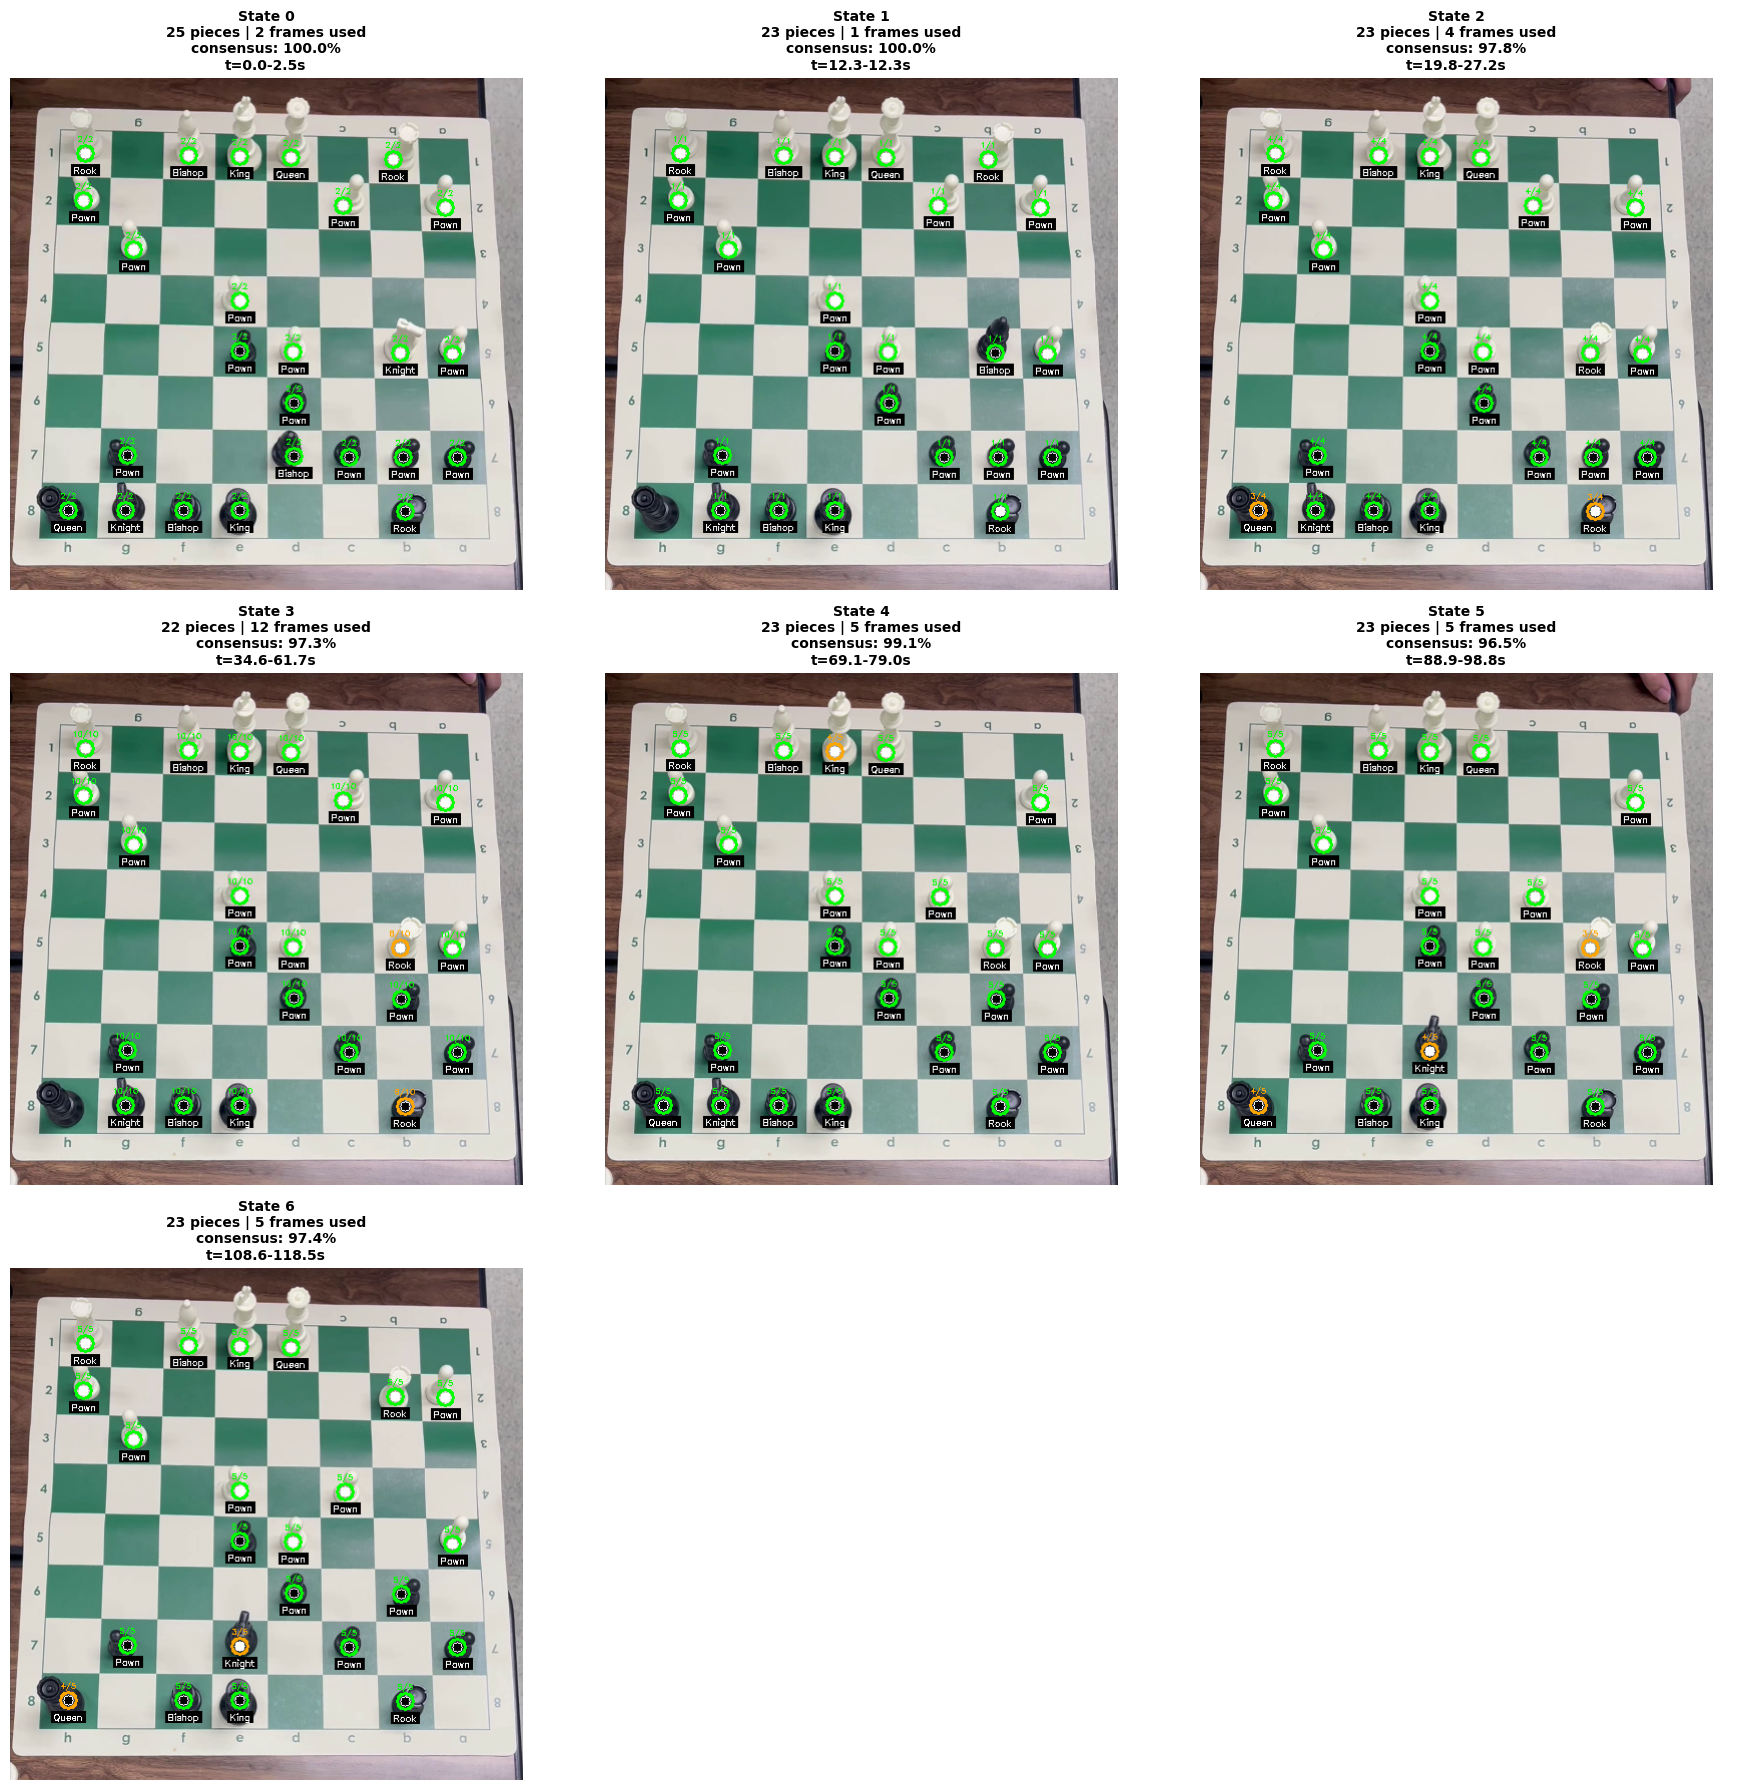

In [8]:
import os
import pandas as pd

VIDEO_FOLDER_PATH = "/home/anawat/JJ/Chula/Chess2PGN/data/video_2"
SAVE_PATH = "/home/anawat/JJ/Chula/Chess2PGN"

df = pd.DataFrame(columns=["row_id", "output"])

for file in os.listdir(VIDEO_FOLDER_PATH):
    if file.endswith(".mp4"):
        # print(f"Processing video: {file}")
        video_file_path = os.path.join(VIDEO_FOLDER_PATH, file)
        pgn_output = process_video(video_file_path, change_threshold=0.055, interval_seconds=2.5, confidence_threshold=0.05, visualize=True)

        df.loc[len(df)] = [file, pgn_output]

df.to_csv(os.path.join(SAVE_PATH, "submission.csv"), index=False)